#### IMPORTAR LIBRERÍAS

In [1]:
# Trabajo de Final de Grado, Grado en Física, 2022-2023
# Redes Neuronales Hamiltonianas
# Oscilador armónico simple
# Francisco Jesús Frías Tenza

import warnings

import matplotlib.pyplot as plt
import matplotlib as mlp
import matplotlib.cm as cm
import matplotlib.colors as colors

from scipy.integrate import solve_ivp

import autograd
import autograd.numpy as np

import argparse
import os, sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow import keras
import tensorflow as tf

import pandas as pd

#### GENERAR DATOS

PARÁMETROS

In [18]:
global system_config
system_config = {"m": 1,
                 "k": 1}

TASA_DE_APRENDIZAJE = 0.005    
CICLOS = 4000           
DIM_OCULTA = 200            

HAMILTONIANO

In [3]:
def H(coords: np.ndarray) -> float:
    """
    Esta función es el hamiltoniano analítico del sistema

    INPUT
    -----
    coords
        array con q, p para cada cuerpo. Las filas son las coordenadas (qx, qy, qz, px, py, pz) y las columnas los cuerpos.
    system_config
        diccionario con los parámetros del sistema, masa, constante elástica, etc.
    """
    q, p = np.split(coords, 2, axis=0)
    m, k = system_config["m"], system_config["k"]
    return p ** 2 / (2 * m) + .5 * k * q ** 2

GRADIENTE SIMPLÉTICO

In [4]:
def SympGrad(t, coords: np.ndarray) -> np.ndarray:
    """
    Esta función calcula el 'symplectic gradient' del hamiltoniano del sistema.
    Para ello, las derivadas se aproximan con una aproximación de O(x^2).
    H: funcion que toma coordenadas y configuracion del sistema
    coords: coordenadas q y p en un determinado valor. las filas son las coordenadas y las columnas los cuerpos
    dcoords: diferencial coordenadas q y p. las filas son las coordenadas y las columnas los cuerpos
    """
    dcoords = autograd.grad(H)(coords)
    S = np.array([[0,  1],
                  [-1, 0]]) @ dcoords
    return S

TRAYECTORIA 

Se integra el gradiente simplético con RK4 para obtener una trayectoria

In [5]:

def trayectoria(t_final: float, t_inicio: float, dt: float, y0: np.ndarray, ruido) -> np.ndarray:
    r"""
    Tomando las ecuaciones de Hamilton $\frac{dq}{dt} = \frac{dH}{dp}$ y $\frac{dq}{dt} = \frac{dH}{dp}$
    vamos a interpretarlas como un sistema de ecuaciones diferenciales del tipo dy/dt = f(x,y,t) sobre las 
    que hay que integrar numericamente. Emplearemos el metodo Runge-Kutta de orden 4 para obtener q(t+dt), p(d+dt).
    h es salto temporal, que va a ser el mismo para las coordenadas.
    """
    N = int((t_final - t_inicio) / dt)
    t_space = np.linspace(t_inicio, t_final, N)
    solu = solve_ivp(fun=SympGrad, t_span=(t_inicio, t_final), y0=y0, t_eval=t_space, atol=1e-5, rtol=1e-5)
    y = solu.y
    #print(y)
    q, p = y[0,:], y[1,:]
    dcoords_dt = np.empty((2, N))
    for i in range(0, N):
        dcoords_dt[:,i] = SympGrad(t=None, coords=y[:,i])
    dqdt, dpdt = dcoords_dt[0,:], dcoords_dt[1,:]

    ## Annadimos ruido a los datos
    q += np.random.randn(*q.shape)*ruido
    p += np.random.randn(*p.shape)*ruido

    H_values = np.array([H(coord.T) for coord in np.concatenate([q[:,None], p[:,None]], axis=1)])

    return q, p, dqdt, dpdt, t_space, dt, H_values

DATASET

Se muestran varias trayectorias para obtner un dataset de datos con q, p, dq, dp

In [6]:

def generate_dataset(semilla=1, muestras=50, test_split=0.7, **kwargs):

    # muestreamos inpus y outputs aleatorios
    np.random.seed(semilla)
    q_data, p_data, dqdt_data, dpdt_data, H_data = [], [], [], [], [] 
    t_final = 10
    for _ in range(muestras):
        y0 = np.random.rand(2, 1) * 20 # generar semillas iniciales aleatorias
        #print(t_final)
        q, p, dq, dp, t_space, dt, H_values = trayectoria(t_final=t_final, t_inicio=0, dt = 0.1, y0=y0.T[0], ruido=0.1)
        #print(q, p, dq, dp)
        #print(q.shape if _ == 1 else pass)
        q_data.append(q); p_data.append(p)
        dqdt_data.append(dq); dpdt_data.append(dp)
        H_data.append(H_values)
    
    split_data = {
        "dq": np.concatenate(dqdt_data, axis=-1), # Y set
        "dp": np.concatenate(dpdt_data, axis=-1),
        "q": np.concatenate(q_data, axis=-1),  # X set
        "p": np.concatenate(p_data, axis=-1),
    }

    df = pd.DataFrame.from_dict(split_data, orient='columns')

        
    # separar en train/test    
    #print(coords)
    #split_ix = int((t_final) / dt * (1 - test_split) ) 
#    split_data = {
#        "coords": np.array(coords[:][split_ix:]).flatten('C'),
#        "test_coords": np.array(coords[:][:split_ix]).flatten('C'),
#        "dcoords": np.array(dcoords[:][split_ix:]).flatten('C'),
#        "test_dcoords": np.array(dcoords[:][:split_ix]).flatten('C'),
#        "H_values": np.array(H_values_list[split_ix:]).flatten('C'),
#        "test_H_values": np.array(H_values_list[:][:split_ix]).flatten('C'),
#    }
    #print(np.concatenate(q_data, axis=-1)[:split_ix].shape)
    #print(np.concatenate(q_data, axis=-1)[split_ix:].shape) 
    #print(np.concatenate(dqdt_data, axis=-1)[:split_ix].shape)
    #print(np.concatenate(dqdt_data, axis=-1)[split_ix:].shape)
    #split_data = {
    #    "dq": np.concatenate(dqdt_data, axis=-1), # Y set
    #    "dq": np.concatenate(dpdt_data, axis=-1),
    #    "q": np.concatenate(q_data, axis=-1),  # X set
    #    "p": np.concatenate(p_data, axis=-1),
        #"H": np.concatenate(H_data, axis=-1)[:split_ix],
    #}
    #split_data_test = {
    #    "test_dq": np.concatenate(dqdt_data, axis=-1)[split_ix:],
    #    "test_dp": np.concatenate(dpdt_data, axis=-1)[split_ix:],
    #    "test_q": np.concatenate(q_data, axis=-1)[split_ix:],
    #    "test_p": np.concatenate(p_data, axis=-1)[split_ix:],
    #    #"test_H": np.concatenate(H_data, axis=-1)[split_ix:]
    #}
    #print(np.array(list(split_data.values())).shape)
    
    return df #split_data_test  

FUNCIONES PARA PLOTS

In [7]:
def get_field(xmin=-1.2, xmax=1.2, ymin=-1.2, ymax=1.2, gridsize=20):
    y_grid, x_grid = np.meshgrid(np.linspace(xmin, xmax, gridsize), np.linspace(ymin, ymax, gridsize))
    dxdt = np.empty_like(y_grid)
    dydt = np.empty_like(x_grid)
    for j, y in enumerate(np.linspace(ymin, ymax, gridsize)):
        for i, x in enumerate(np.linspace(xmin, xmax, gridsize)):
            aux = SympGrad(None, coords=np.array([x,y]).T)
            dxdt[i,j], dydt[i,j] = aux[0], aux[1] 
    return x_grid, y_grid, dxdt, dydt


def plot_figures(q, p, dqdt, dpdt, t_space, dt):
    
    x_grid, y_grid, dxdt, dydt = get_field(gridsize=15)
    color = mlp.colormaps['Reds']

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(w=11, h=5)
    ax1_twinx = ax1.twinx()

    ax1.plot(t_space, q, "r-", label=r"$q(t)$")
    ax1.set_ylabel('Posición (m)', )
    ax1.xaxis.label.set_color('black')
    ax1.yaxis.label.set_color('red')
    ax1.tick_params(colors='red', axis='y')

    ax1_twinx.plot(t_space, p, "b-", label=r"$p(t)$")  
    ax1_twinx.set_xlabel('Tiempo (s)')
    ax1_twinx.set_ylabel('Velocidad (m/s)')
    ax1_twinx.xaxis.label.set_color('black')
    ax1_twinx.yaxis.label.set_color('blue')
    ax1_twinx.tick_params(colors='blue', axis='y')

    ax2.scatter(q[::10], p[::10], c=np.sqrt(p[::10]**2 + q[::10]**2), cmap=color, label="Espacio de Fase")
    ax2.quiver(x_grid, y_grid, dxdt, dydt, cmap='PRGn', color=(.5,.5,.5))
    ax2.set_xlabel("q")
    ax2.set_ylabel("p")
    ax2.legend(bbox_to_anchor=(0.95, 1.15))
    
    fig.suptitle("Analisis del oscilador armonico simples")

    plt.show()

def plot_figures_compare(q, p, dqdt, dpdt, t_space, dt):

    x_grid, y_grid, dxdt, dydt = get_field(gridsize=15)

    q_prec, p_prec, dqdt_prec, dpdt_prec, *args = trayectoria(t_final=10, t_inicio=0, dt=0.01, y0=np.array([1,0]), ruido=0.0)


    N = len(q)
    color = mlp.colormaps['Reds']
    color_aux = mlp.colormaps['Blues']
    color_ranges = np.sqrt(p[::10]**2/2 + q[::10]**2/2)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
    fig.set_size_inches(w=11, h=11)
    fig.tight_layout(pad=6.5)
    ax1_twinx = ax1.twinx()
    ax3_twinx = ax3.twinx()

    ax1.plot(t_space, q_prec, "r-", label=r"$q(t)$")
    ax1.set_ylabel('Posición (m)', )
    ax1.xaxis.label.set_color('black')
    ax1.yaxis.label.set_color('red')
    ax1.tick_params(colors='red', axis='y')

    ax1_twinx.plot(t_space, p_prec, "b-", label=r"$p(t)$")  
    ax1.set_xlabel('Tiempo (s)')
    ax1_twinx.set_ylabel('Velocidad (m/s)')
    ax1_twinx.xaxis.label.set_color('black')
    ax1_twinx.yaxis.label.set_color('blue')
    ax1_twinx.tick_params(colors='blue', axis='y')
    ax1.legend(bbox_to_anchor=(0.75, 1.2))
    ax1_twinx.legend(bbox_to_anchor=(0.95, 1.2))

    ax2.scatter(q[::10], p[::10], c=np.sqrt(p[::10]**2 + q[::10]**2), cmap=color, label="Espacio de Fase")
    ax2.quiver(x_grid, y_grid, dxdt, dydt, cmap='PRGn', color=(.5,.5,.5))
    ax2.set_xlabel("q")
    ax2.set_ylabel("p")
    ax2.legend(bbox_to_anchor=(0.95, 1.15))

    ax3.plot(t_space, np.cos(t_space), color="blue", linestyle="dashed", label=r"$q(t)$ solucion analítica")
    ax3_twinx.plot(t_space, -np.sin(t_space), color="cyan", linestyle="dashed", label=r"$p(t)$ solucion analítica")
    ax3.plot(t_space, q_prec, "r-", label=r"$q(t)$ solución numérica")
    ax3_twinx.plot(t_space, p_prec, color="orange", label=r"$p(t)$ solución numérica")  
    ax3.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
            ncol=3, fancybox=True, shadow=False)    
    ax3_twinx.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
          ncol=3, fancybox=True, shadow=False)
    ax3.set_ylabel('Posición (m)', )
    #ax3.tick_params(colors='red', axis='y')
    ax3.set_xlabel('Tiempo (s)')
    ax3_twinx.set_ylabel('Velocidad (m/s)')
    #ax3_twinx.tick_params(colors='blue', axis='y')

    ax4.scatter(q_prec[::10], p_prec[::10], s=20, c=color_ranges, cmap=color, 
                norm=colors.CenteredNorm(vcenter=color_ranges.max()/2,
                                         halfrange=color_ranges.max()/2, clip=True),
                #vmin=0, vmax=color_ranges.max(),
                label="Resultado numérico")
    ax4.scatter(np.cos(t_space[::10]), -np.sin(t_space[::10]), s=2, c=color_ranges, cmap=color_aux, 
                norm=colors.CenteredNorm(vcenter=color_ranges.max()/2,
                                         halfrange=color_ranges.max()/2, clip=True),
                #vmin=0, vmax=color_ranges.max(),
                label="Resultado analítico")
    ax4.quiver(x_grid, y_grid, dxdt, dydt, cmap='PRGn', color=(.5,.5,.5), alpha=0.5)
    ax4.set_xlabel("q")
    ax4.legend(loc='center left', bbox_to_anchor=(0.75, 0.9))
    ax4.set_ylabel("p")
    
    
    #ax4.scatter(q[::2], p[::2], c=np.sqrt(p**2 + q**2), label="Espacio de Fase")
    
    fig.savefig(r".\img\OsArm_figs_{}_{}.png".format(int(q[0]), int(p[0])))


#### DEFINICIÓN DE LOS MODELOS

Red Neuronal Hamiltoniana HNN

In [8]:
class HNN(tf.Module):
  
  def __init__(self, dim_entrada, dim_oculta, name=None):
    super().__init__(name=name)
    self.dim_entrada = dim_entrada
    self.dim_oculta = dim_oculta
    self.capa1 = tf.keras.layers.InputLayer(input_shape=self.dim_entrada) # Input layer
    self.capa2 = tf.keras.layers.Dense(units=self.dim_oculta, activation='tanh',
                                       kernel_initializer=tf.initializers.glorot_normal(1)) # Output layer
    # Si se busca crear más capas, ha de copiarse y pegar el siguiente código
    # self.capa_n = tf.keras.layers.Dense(units=dim_oculta, activation='tanh') # donde "_n" es u numero natural
    self.capa3 = tf.keras.layers.Dense(1)
    O = np.zeros((dim_entrada//2, dim_entrada//2))
    I = np.identity(dim_entrada//2)
    R_90 = np.concatenate([np.concatenate((O, I), axis=1), np.concatenate((-I, O), axis=1)], axis=0)
    self.R_90 = tf.constant(R_90, dtype='double')

  @tf.Module.with_name_scope
  def __call__(self, x):
    for key_capa, capa in {k:self.__dict__[k] for k in self.__dict__.keys() if "capa" in k}.items():
      print(capa)
      x = self.__dict__[capa](x)
    return x
  
  def compute_symplectic_gradient(self, x):
    with tf.GradientTape() as tape:
      tape.watch(x)
      for key_capa, capa in {k:self.__dict__[k] for k in self.__dict__.keys() if "capa" in k}.items():
        if "1" in key_capa:
          y = capa(x)
        elif map(lambda string: any(char in np.array(["2", "3", "4", "5"]) for char in string), key_capa):
          y = capa(y)
    y = tape.gradient(y, x)
    y = y @ np.linalg.inv(self.R_90)
    return y
  
  def entrenar_HNN(self, data, tasa_de_aprendizaje = TASA_DE_APRENDIZAJE, ciclos = CICLOS, verbose=True, verbose_pesos=False, return_loss=True):
    warnings.filterwarnings('ignore')
    # Tomamos el algoritmo Adam para optimización
    adam_aldoritmo = tf.keras.optimizers.Adam(learning_rate=tasa_de_aprendizaje)
    if return_loss:
      loss_array = np.zeros(ciclos+1)
    # Declaramos la función de coste
    funcion_coste_L2 = tf.keras.losses.MeanSquaredError()
    ciclo = 0
    while ciclo <= ciclos:
        with tf.GradientTape() as tape_coste: # Este es el gradiente de la función de coste
            tape_coste.watch(self.trainable_variables) # Esto nos permite 'vigilar' las variables de TensorFlow
            y_train_keys = [key for key in data.columns if 'd' in key]
            y_test_keys = [key for key in data.columns if 'd' not in key]
            y_pred = self.compute_symplectic_gradient(tf.Variable(tf.stack(data[y_train_keys]))) # SympGrad del Hamiltoniano
            y_real = tf.Variable(tf.stack(data[y_test_keys]))
            loss = funcion_coste_L2(y_pred=y_pred, y_true=y_real) # Evaluación de la función de coste
        # Creamos el gradiente
        gradiente_funcion_coste_L2 = tape_coste.gradient(loss, self.trainable_variables)
        # El siguiente paso es opcional, usamos esto para agilizar el entrenamiento
        adam_aldoritmo.apply_gradients(zip(gradiente_funcion_coste_L2, self.trainable_variables))

        if verbose:
          print("Ciclo: {} \nFunción de Coste: {}".format(ciclo, loss))
          if verbose_pesos:
            for key_pesos, pesos in {k:self.__dict__[k] for k in self.__dict__.keys() if "capa" in k}.items():
              print("Capa {}: {}".format(key_pesos, pesos.get_weights()))

        if return_loss:
          loss_array[ciclo] = loss

        ciclo += 1
    warnings.resetwarnings()
    return loss_array


ENTRENAMIENTO DE LA RED NEURONAL

In [17]:
hnn_modelo = HNN(dim_entrada=2, dim_oculta=DIM_OCULTA)
loss = hnn_modelo.entrenar_HNN(data=generate_dataset(), tasa_de_aprendizaje=TASA_DE_APRENDIZAJE, ciclos=CICLOS)

Ciclo: 0 
Función de Coste: 144.97522242167852
Ciclo: 1 
Función de Coste: 144.85488898689886
Ciclo: 2 
Función de Coste: 144.74089111640282
Ciclo: 3 
Función de Coste: 144.63278262508084
Ciclo: 4 
Función de Coste: 144.52953289928791
Ciclo: 5 
Función de Coste: 144.42994662222122
Ciclo: 6 
Función de Coste: 144.33262906649972
Ciclo: 7 
Función de Coste: 144.23612726108237
Ciclo: 8 
Función de Coste: 144.13921612641806
Ciclo: 9 
Función de Coste: 144.04076054791747
Ciclo: 10 
Función de Coste: 143.93961911250219
Ciclo: 11 
Función de Coste: 143.83465157373507
Ciclo: 12 
Función de Coste: 143.7247680949004
Ciclo: 13 
Función de Coste: 143.60918671892742
Ciclo: 14 
Función de Coste: 143.48783448413903
Ciclo: 15 
Función de Coste: 143.36128740293123
Ciclo: 16 
Función de Coste: 143.23046346318174
Ciclo: 17 
Función de Coste: 143.09623565369014
Ciclo: 18 
Función de Coste: 142.95903330340184
Ciclo: 19 
Función de Coste: 142.81859023760245
Ciclo: 20 
Función de Coste: 142.67418324604196
Cic

KeyboardInterrupt: 

In [14]:
def integrar_HNN(modelo, **kwargs):
    return solve_ivp(fun=lambda t, x: modelo.compute_symplectic_gradient(tf.Variable(tf.reshape(x, (1, modelo.dim_entrada)), dtype='double')), **kwargs)

DEMOSTRACIÓN

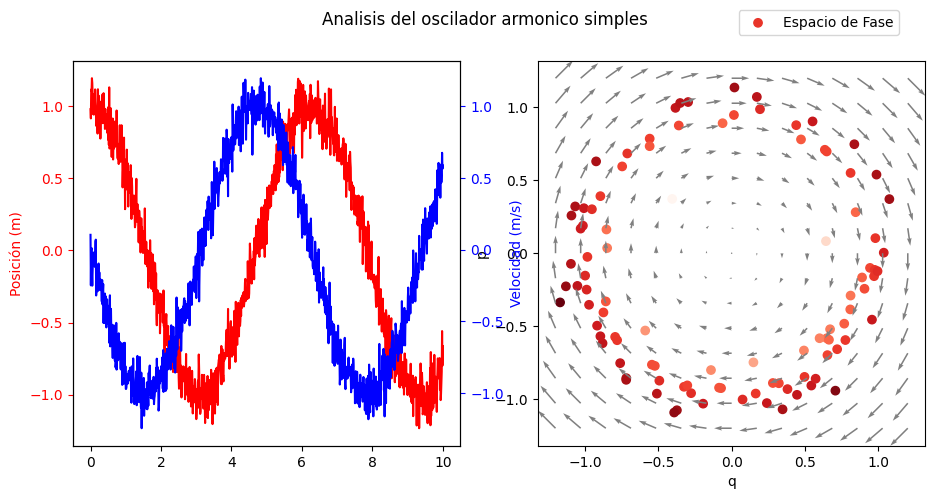

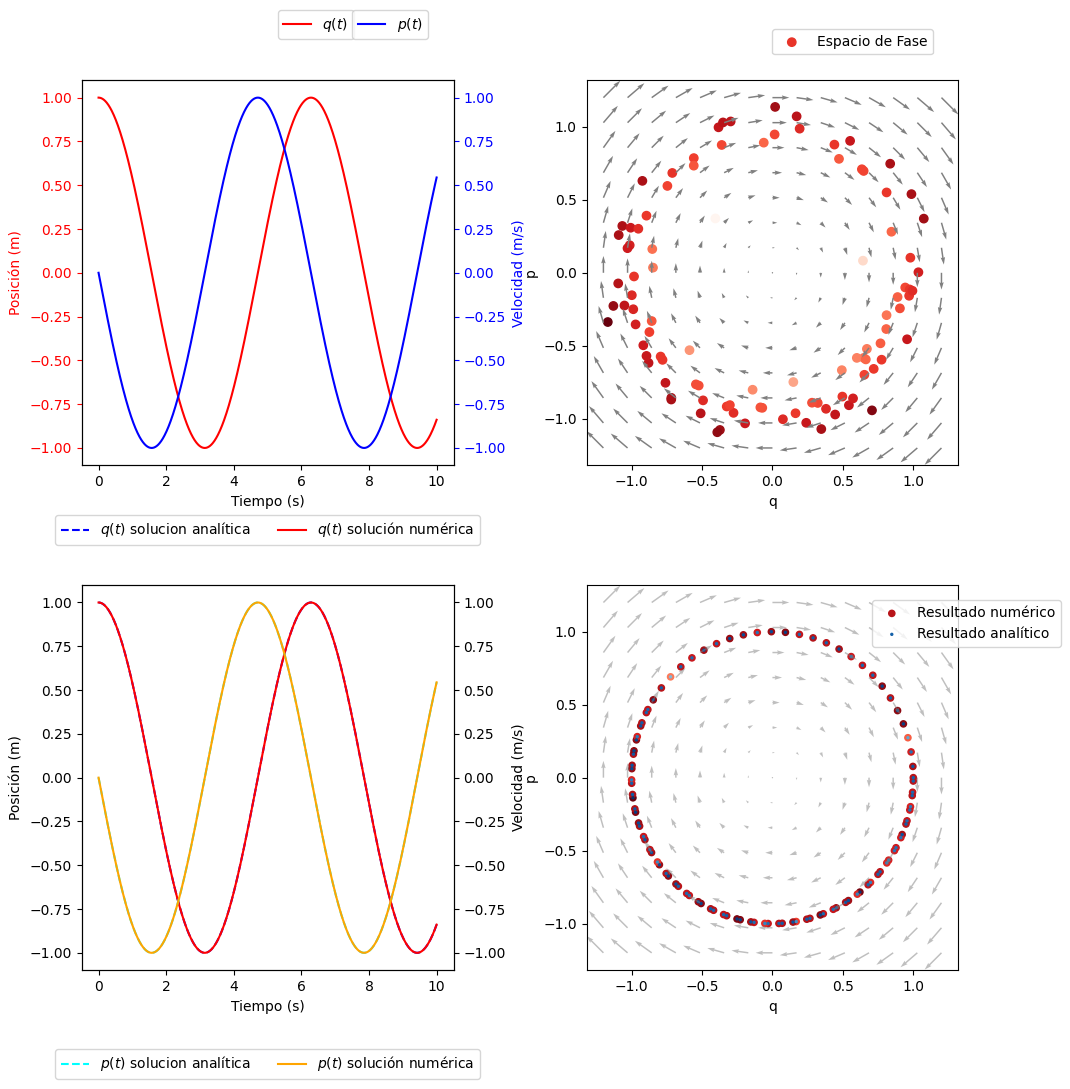

In [ ]:
q, p, dqdt, dpdt, t_space, dt, H_values = trayectoria(t_final=10, t_inicio=0, dt=0.01, y0=np.array([1,0]), ruido=0.1)
plot_figures(q, p, dqdt, dpdt, t_space, dt)
plot_figures_compare(q, p, dqdt, dpdt, t_space, dt)

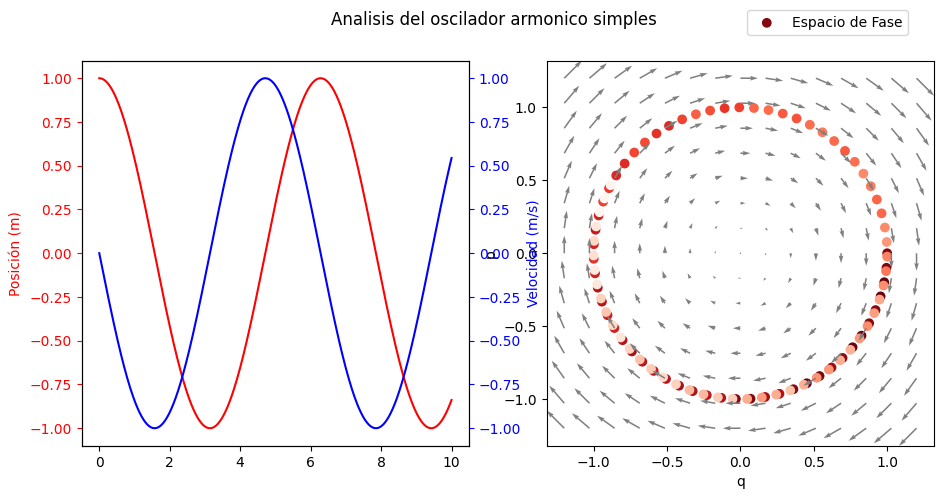

In [ ]:
q, p, dqdt, dpdt, t_space, *_ = trayectoria(t_final=10, t_inicio=0, dt=0.01, y0=np.array([1,0]), ruido=0.0)
plot_figures(q, p, dqdt, dpdt, t_space, dt)

Análisis

In [ ]:
t_span = [0,20]
t_puntos = 2000
t_eval = np.linspace(t_span[0], t_span[1], t_puntos)
atol = 1e-9; rtol = 1e-9
y0 = np.array([1, 0])
kwargs = {'y0': y0, 't_span': t_span, 't_eval': t_eval, 'rtol': rtol, 'atol': atol}
hnn_trayectoria = integrar_HNN(hnn_modelo, **kwargs)

In [ ]:
print(hnn_trayectoria)
print(hnn_trayectoria['y'])

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.001e-02 ...  1.999e+01  2.000e+01]
        y: [[ 1.000e+00  9.991e-01 ... -9.077e-02 -9.736e-02]
            [ 0.000e+00  6.712e-03 ...  8.118e-01  8.107e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 6794
     njev: 0
      nlu: 0
[[ 1.          0.99905904  0.99807067 ... -0.08416313 -0.09076739
  -0.09736417]
 [ 0.          0.00671194  0.01341647 ...  0.81282123  0.811808
   0.81074854]]


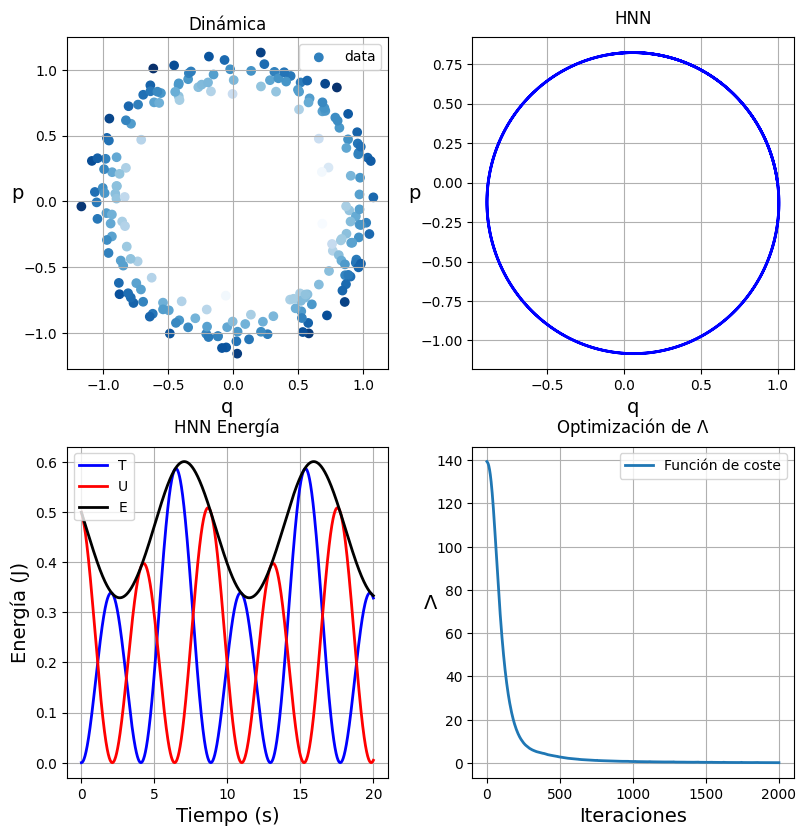

In [ ]:
T = lambda x: x**2/(2*system_config['m'])
U = lambda x: 0.5 * system_config['k'] * x**2

color = mlp.colormaps['Blues']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(8, 8)
fig.tight_layout(pad=1.1, h_pad=3.5, w_pad=3)


x, y, dx, dy, t, dt, H_values = trayectoria(t_final=20, t_inicio=0, dt=0.01, y0=np.array([1, 0]), ruido=0.1)

ax1.scatter(x[::10], y[::10], c=np.sqrt(x[::10]**2 + y[::10]**2), cmap=color, label='data')
ax1.set_xlabel("q", fontsize=14)
ax1.set_ylabel("p", rotation=0, fontsize=14)
ax1.set_title("Dinámica")
ax1.legend(loc='upper right')
ax1.grid()

ax2.plot(hnn_trayectoria['y'].T[:,0], hnn_trayectoria['y'].T[:,1], color='b', linewidth=2)    
ax2.set_xlabel("q", fontsize=14)
ax2.set_ylabel("p", rotation=0, fontsize=14)
ax2.set_title("HNN", pad=10)
ax2.grid()

U_energias = U(hnn_trayectoria['y'].T[:,0])
T_energias = T(hnn_trayectoria['y'].T[:,1])
E_energias = T_energias + U_energias

ax3.plot(t, T_energias, color='b', linewidth=2, label="T")
ax3.plot(t, U_energias, color='r', linewidth=2, label="U")
ax3.plot(t, E_energias, color='k', linewidth=2, label="E")    
ax3.set_xlabel("Tiempo (s)", fontsize=14)
ax3.set_ylabel("Energía (J)", rotation=90, fontsize=14)
ax3.set_title("HNN Energía", pad=10)
ax3.legend()
ax3.grid()

ax4.plot(np.arange(len(loss)), loss, linewidth=2, label="Función de coste")    
ax4.set_xlabel("Iteraciones", fontsize=14)
ax4.set_ylabel(r"$\Lambda$", rotation=0, fontsize=14)
ax4.set_title(r"Optimización de $\Lambda$", pad=10)
ax4.legend()
ax4.grid()

plt.savefig(r".\img\hnn_pred_{}_{}.png".format(int(x[0]), int(y[0])))

In [19]:
data = generate_dataset() #5000
atol = 1e-9; rtol = 1e-9
kwargs = {'y0': np.array([1, 0]), 't_span': [0, 10], 't_eval': np.linspace(0, 10, 100), 'rtol': rtol, 'atol': atol}

q, p, dq, dp, *_= trayectoria(t_final=10, t_inicio=0, dt=0.1, y0=np.array([1, 0]), ruido=0)

hnn_modelo_50 = HNN(dim_entrada=2, dim_oculta=50, name="HNN_os_arm_50n")
hnn_modelo_50.entrenar_HNN(data=data, tasa_de_aprendizaje=TASA_DE_APRENDIZAJE, ciclos=CICLOS, verbose=True)
q50, p50 = integrar_HNN(hnn_modelo_50, **kwargs)['y']

hnn_modelo_100 = HNN(dim_entrada=2, dim_oculta=100, name="HNN_os_arm_100n")
hnn_modelo_100.entrenar_HNN(data=data, tasa_de_aprendizaje=TASA_DE_APRENDIZAJE, ciclos=CICLOS, verbose=True)
q100, p100 = integrar_HNN(hnn_modelo_100, **kwargs)['y']

hnn_modelo_150 = HNN(dim_entrada=2, dim_oculta=150, name="HNN_os_arm_150n")
hnn_modelo_150.entrenar_HNN(data=data, tasa_de_aprendizaje=TASA_DE_APRENDIZAJE, ciclos=CICLOS, verbose=True)
q150, p150 = integrar_HNN(hnn_modelo_150, **kwargs)['y']

hnn_modelo_200 = HNN(dim_entrada=2, dim_oculta=200, name="HNN_os_arm_200n")
hnn_modelo_200.entrenar_HNN(data=data, tasa_de_aprendizaje=TASA_DE_APRENDIZAJE, ciclos=CICLOS, verbose=True)
q200, p200 = integrar_HNN(hnn_modelo_200, **kwargs)['y']

hnn_modelo_250 = HNN(dim_entrada=2, dim_oculta=250, name="HNN_os_arm_250n")
hnn_modelo_250.entrenar_HNN(data=data, tasa_de_aprendizaje=TASA_DE_APRENDIZAJE, ciclos=CICLOS, verbose=True)
q250, p250 = integrar_HNN(hnn_modelo_250, **kwargs)['y']

hnn_modelo_300 = HNN(dim_entrada=2, dim_oculta=300, name="HNN_os_arm_300n")
hnn_modelo_300.entrenar_HNN(data=data, tasa_de_aprendizaje=TASA_DE_APRENDIZAJE, ciclos=CICLOS, verbose=True)
q300, p300 = integrar_HNN(hnn_modelo_300, **kwargs)['y']

hnn_modelo_350 = HNN(dim_entrada=2, dim_oculta=350, name="HNN_os_arm_350n")
hnn_modelo_350.entrenar_HNN(data=data, tasa_de_aprendizaje=TASA_DE_APRENDIZAJE, ciclos=CICLOS, verbose=True)
q350, p350 = integrar_HNN(hnn_modelo_350, **kwargs)['y']

hnn_modelo_400 = HNN(dim_entrada=2, dim_oculta=400, name="HNN_os_arm_400n")
hnn_modelo_400.entrenar_HNN(data=data, tasa_de_aprendizaje=TASA_DE_APRENDIZAJE, ciclos=CICLOS, verbose=True)
q400, p400 = integrar_HNN(hnn_modelo_400, **kwargs)['y']

hnn_modelo_450 = HNN(dim_entrada=2, dim_oculta=450, name="HNN_os_arm_450n")
hnn_modelo_450.entrenar_HNN(data=data, tasa_de_aprendizaje=TASA_DE_APRENDIZAJE, ciclos=CICLOS, verbose=True)
q450, p450 = integrar_HNN(hnn_modelo_450, **kwargs)['y']


Ciclo: 0 
Función de Coste: 144.9835846018671
Ciclo: 1 
Función de Coste: 144.96497833808192
Ciclo: 2 
Función de Coste: 144.94781068967288
Ciclo: 3 
Función de Coste: 144.9326030724023
Ciclo: 4 
Función de Coste: 144.91959873299103
Ciclo: 5 
Función de Coste: 144.90875893748094
Ciclo: 6 
Función de Coste: 144.89982348210145
Ciclo: 7 
Función de Coste: 144.8924013133278
Ciclo: 8 
Función de Coste: 144.886060964526
Ciclo: 9 
Función de Coste: 144.88040013569946
Ciclo: 10 
Función de Coste: 144.87508438083566
Ciclo: 11 
Función de Coste: 144.8698546510935
Ciclo: 12 
Función de Coste: 144.86451602397895
Ciclo: 13 
Función de Coste: 144.8589247388969
Ciclo: 14 
Función de Coste: 144.85298138440183
Ciclo: 15 
Función de Coste: 144.84662801304526
Ciclo: 16 
Función de Coste: 144.83984254229205
Ciclo: 17 
Función de Coste: 144.83262958819495
Ciclo: 18 
Función de Coste: 144.82500994668916
Ciclo: 19 
Función de Coste: 144.81701175975704
Ciclo: 20 
Función de Coste: 144.8086651458042
Ciclo: 21 

In [ ]:
N = 100
error_100 = 1/N * np.array([np.linalg.norm(qi - qi10) + np.linalg.norm(pi - pi10) for qi, qi10, pi, pi10 in zip(q, q100, p, p100)]).sum()
error_150 = 1/N * np.array([np.linalg.norm(qi - qi10) + np.linalg.norm(pi - pi10) for qi, qi10, pi, pi10 in zip(q, q150, p, p150)]).sum()
error_200 = 1/N * np.array([np.linalg.norm(qi - qi10) + np.linalg.norm(pi - pi10) for qi, qi10, pi, pi10 in zip(q, q200, p, p200)]).sum()
error_250 = 1/N * np.array([np.linalg.norm(qi - qi10) + np.linalg.norm(pi - pi10) for qi, qi10, pi, pi10 in zip(q, q250, p, p250)]).sum()
error_300 = 1/N * np.array([np.linalg.norm(qi - qi10) + np.linalg.norm(pi - pi10) for qi, qi10, pi, pi10 in zip(q, q300, p, p300)]).sum()
error_350 = 1/N * np.array([np.linalg.norm(qi - qi10) + np.linalg.norm(pi - pi10) for qi, qi10, pi, pi10 in zip(q, q350, p, p350)]).sum()
error_400 = 1/N * np.array([np.linalg.norm(qi - qi10) + np.linalg.norm(pi - pi10) for qi, qi10, pi, pi10 in zip(q, q400, p, p400)]).sum()
error_450 = 1/N * np.array([np.linalg.norm(qi - qi10) + np.linalg.norm(pi - pi10) for qi, qi10, pi, pi10 in zip(q, q450, p, p450)]).sum()

errores = np.array([error_100, error_150, error_200, error_250, error_300, error_350, error_400, error_450,])

fig, ax = plt.subplots()
ax.scatter(np.array([100, 150, 200, 250, 300, 350, 400, 450]), errores, label="Errores")
ax.set_xlabel("Neuronas")
ax.set_ylabel("Error")
ax.set_xticks(np.array([100, 150, 200, 250, 300, 350, 400, 450]))
ax.legend()
ax.set_title("Progresión del error en el número de neuronas")